# Dynamic Network Analysis: Reddit r/depression Community Evolution (2009-2024)

This notebook analyzes the evolution of the r/depression community network over 16 years.

**Key Focus**: Temporal dynamics - how the network structure, user roles, and communities change over time.

**Data Source**: Pre-computed yearly edge lists in `yearly_graphs/edges_YYYY.csv`

**Architecture**: Function-driven, cached analysis with configurable parameters.

## Section 1: Setup, Configuration, and Imports

In [2]:
import pandas as pd
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import os
import pickle
import warnings
import time
from pathlib import Path
from typing import Dict, Tuple, List, Any
import scipy.stats as stats
from concurrent.futures import ProcessPoolExecutor, as_completed

warnings.filterwarnings('ignore')

print("All imports successful.")

All imports successful.


### Configuration Dictionary

All analysis parameters are centralized here. Modify these to change behavior.

In [3]:
# Analysis configuration
config = {
    # Years to analyze
    'years': list(range(2009, 2025)),
    'test_years': [2009, 2015, 2019],  # Subset for testing
    
    # Output
    'cache_dir': 'analysis_cache',
    'fig_dir': 'figures',
    'data_dir': 'yearly_graphs',
    
    # Analysis parameters
    'top_n_users': 10,  # Top N users to track
    'top_n_communities': 5,  # Top N communities to analyze
    
    # Community detection
    'community_method': 'louvain',  # Primary: 'louvain' (fast + high quality)
    'use_label_propagation_comparison': True,  # Also compute label propagation for comparison
    
    # Caching
    'use_cache': True,
    'cache_validation': True,  # Check if cached files are newer than source
    
    # Plotting
    'plot_dpi': 150,
    'plot_style': 'whitegrid',
    'figsize_default': (14, 8),
    
    # Random seed for reproducibility
    'random_seed': 42,
}

# Create directories
Path(config['cache_dir']).mkdir(exist_ok=True)
Path(config['fig_dir']).mkdir(exist_ok=True)

# Set plotting defaults
sns.set_style(config['plot_style'])
plt.rcParams['figure.figsize'] = config['figsize_default']
np.random.seed(config['random_seed'])

print("Configuration loaded.")
print(f"Analysis years: {config['years'][0]}-{config['years'][-1]}")
print(f"Cache directory: {config['cache_dir']}")
print(f"Figures directory: {config['fig_dir']}")

Configuration loaded.
Analysis years: 2009-2024
Cache directory: analysis_cache
Figures directory: figures


## Section 2: Utility Functions

### Caching Utilities

In [4]:
def get_cache_file(year: int, metric_type: str, config: Dict) -> str:
    """
    Generate cache file path for a given year and metric type.
    
    Parameters:
        year: int, year identifier
        metric_type: str, 'metrics', 'communities', 'graph'
        config: dict, configuration dict
    
    Returns:
        path: str, full cache file path
    """
    return os.path.join(config['cache_dir'], f"{metric_type}_{year}.pkl")


def load_or_compute(year: int, metric_type: str, compute_fn, config: Dict, force_recompute: bool = False):
    """
    Load from cache or compute and cache a result.
    
    Parameters:
        year: int
        metric_type: str
        compute_fn: callable, function that computes the metric
        config: dict
        force_recompute: bool, skip cache
    
    Returns:
        result from cache or computed
    """
    if not config['use_cache']:
        return compute_fn()
    
    cache_file = get_cache_file(year, metric_type, config)
    
    if not force_recompute and os.path.exists(cache_file):
        try:
            with open(cache_file, 'rb') as f:
                return pickle.load(f)
        except Exception as e:
            print(f"  Warning: Cache load failed ({e}), recomputing...")
    
    # Compute
    result = compute_fn()
    
    # Save to cache
    try:
        with open(cache_file, 'wb') as f:
            pickle.dump(result, f)
    except Exception as e:
        print(f"  Warning: Cache save failed ({e})")
    
    return result


print("Caching utilities loaded.")

Caching utilities loaded.


### Data Loading and Validation

In [5]:
def load_graph(year: int, config: Dict, validate: bool = True) -> Tuple[ig.Graph, Dict[str, Any]]:
    """
    Load yearly edge list and construct directed graph.
    
    Parameters:
        year: int, year to load
        config: dict, configuration
        validate: bool, perform data quality checks
    
    Returns:
        graph: igraph.Graph (directed)
        metadata: dict with quality metrics
    
    Raises:
        FileNotFoundError: if edge list file doesn't exist
        ValueError: if graph is empty after filtering
    """
    edge_file = os.path.join(config['data_dir'], f'edges_{year}.csv')
    
    if not os.path.exists(edge_file):
        raise FileNotFoundError(f"Edge file not found: {edge_file}")
    
    # Load edges
    df_edges = pd.read_csv(edge_file)
    
    if len(df_edges) == 0:
        raise ValueError(f"Year {year}: No edges found in {edge_file}")
    
    # Construct graph from edge list
    edge_tuples = list(zip(df_edges['source'], df_edges['target']))
    G = ig.Graph.TupleList(edge_tuples, directed=True)
    
    # Compute metadata
    metadata = {
        'year': year,
        'num_nodes': G.vcount(),
        'num_edges': G.ecount(),
        'num_isolated_nodes': sum(1 for d in G.degree() if d == 0),
        'density': G.density(),
        'is_directed': G.is_directed(),
    }
    
    # Connectivity info
    components = G.connected_components(mode='weak')
    metadata['num_components'] = len(components)
    metadata['giant_component_size'] = max(components.sizes()) if components.sizes() else 0
    metadata['giant_component_pct'] = 100 * metadata['giant_component_size'] / metadata['num_nodes'] if metadata['num_nodes'] > 0 else 0
    
    return G, metadata


print("Data loading function defined.")

Data loading function defined.


## Section 3: Core Analysis Functions

### Basic Metrics (Fast)

These are O(V+E) operations and computed for all graphs.

In [6]:
def compute_basic_metrics(G: ig.Graph) -> Dict[str, Any]:
    """
    Compute basic graph metrics.
    
    Returns:
        dict with metrics
    """
    n_nodes = G.vcount()
    n_edges = G.ecount()
    
    if n_nodes == 0:
        return {}
    
    # Degree statistics
    degree_out = G.degree(mode='out')
    degree_in = G.degree(mode='in')
    
    metrics = {
        'avg_degree_out': np.mean(degree_out),
        'avg_degree_in': np.mean(degree_in),
        'avg_degree_total': (2 * n_edges) / n_nodes,  # For undirected equivalent
        'max_degree_out': max(degree_out),
        'max_degree_in': max(degree_in),
        'std_degree_out': np.std(degree_out),
        'std_degree_in': np.std(degree_in),
        'density': G.density(),
    }
    
    # Clustering (undirected version)
    G_undirected = G.as_undirected(mode='collapse')
    metrics['transitivity'] = G_undirected.transitivity_undirected()
    metrics['avg_local_clustering'] = G_undirected.transitivity_avglocal_undirected()
    
    # Reciprocity
    metrics['reciprocity'] = G.reciprocity()
    
    return metrics


print("Basic metrics function defined.")

Basic metrics function defined.


### Centrality Metrics

PageRank, degree centrality, and harmonic centrality (instead of betweenness).

In [7]:
def compute_centrality_metrics(G: ig.Graph, config: Dict) -> Dict[str, Any]:
    """
    Compute centrality metrics and identify top users.
    
    Uses PageRank, degree centrality, and harmonic centrality.
    Avoids betweenness which has O(V*E) complexity and was using cutoff approximation.
    
    Returns:
        dict with centrality metrics and top-N users
    """
    if G.vcount() == 0:
        return {}
    
    node_names = G.vs['name']
    n = len(node_names)
    top_n = config['top_n_users']
    
    # Degree centrality
    degree_out = G.degree(mode='out')
    degree_in = G.degree(mode='in')
    
    # PageRank
    pagerank = G.pagerank()
    
    # Harmonic centrality
    # Uses igraph's optimized built-in method (implemented in C, much faster than naive O(n²) implementation)
    # Identifies nodes that are centrally positioned (important bridges/hubs)
    # Harmonic centrality = sum of 1/distance to reachable nodes (naturally handles disconnected components)
    harmonic_centrality = G.harmonic_centrality(mode='all')
    
    # Find top users by each metric
    top_by_outdegree = sorted(
        zip(node_names, degree_out),
        key=lambda x: x[1],
        reverse=True
    )[:top_n]
    
    top_by_indegree = sorted(
        zip(node_names, degree_in),
        key=lambda x: x[1],
        reverse=True
    )[:top_n]
    
    top_by_pagerank = sorted(
        zip(node_names, pagerank),
        key=lambda x: x[1],
        reverse=True
    )[:top_n]
    
    top_by_harmonic = sorted(
        zip(node_names, harmonic_centrality),
        key=lambda x: x[1],
        reverse=True
    )[:top_n]
    
    return {
        'degree_out': degree_out,
        'degree_in': degree_in,
        'pagerank': pagerank,
        'harmonic_centrality': harmonic_centrality,
        'top_outdegree': top_by_outdegree,
        'top_indegree': top_by_indegree,
        'top_pagerank': top_by_pagerank,
        'top_harmonic': top_by_harmonic,
        'node_names': node_names,
    }


print("Centrality metrics function defined.")

Centrality metrics function defined.


### Community Detection

Uses directed label propagation as primary method, with optional Louvain comparison.

In [8]:
def compute_communities(G: ig.Graph, config: Dict) -> Dict[str, Any]:
    """
    Detect communities using Louvain method with optional label propagation comparison.
    
    PERFORMANCE FIX (2024-12-31):
    - Label propagation on DIRECTED graphs: 60+ minutes for 2012 (UNUSABLE)
    - Label propagation on UNDIRECTED graphs: 0.19s for 2012 (fast)
    - Louvain on UNDIRECTED graphs: 0.21s for 2012, 2.0s for 2019 (fast + high quality)
    
    Primary method: Louvain (modularity optimization, widely used, high quality)
    Optional: Label propagation (undirected) for comparison
    
    Returns:
        dict with community structures and stats
    """
    if G.vcount() == 0:
        return {}
    
    node_names = G.vs['name']
    
    # Convert to undirected (required for both methods)
    G_undirected = G.as_undirected(mode='collapse')
    
    # Primary method: Louvain community detection
    communities_louvain = G_undirected.community_multilevel()
    community_sizes_louvain = communities_louvain.sizes()
    
    result = {
        'method': 'louvain',
        'num_communities': len(community_sizes_louvain),
        'community_sizes': community_sizes_louvain,
        'avg_community_size': np.mean(community_sizes_louvain),
        'max_community_size': max(community_sizes_louvain),
        'modularity': communities_louvain.modularity,
        'communities': communities_louvain,
        'communities_membership': communities_louvain.membership,
    }
    
    # Optional: Label propagation (undirected) for comparison
    if config.get('use_label_propagation_comparison', False):
        communities_lp = G_undirected.community_label_propagation()
        
        result['label_propagation'] = {
            'num_communities': len(communities_lp),
            'community_sizes': communities_lp.sizes(),
            'avg_community_size': np.mean(communities_lp.sizes()),
            'max_community_size': max(communities_lp.sizes()),
        }
    
    return result


print("Community detection function defined.")

Community detection function defined.


### Master Analysis Function

In [9]:
def analyze_year(year: int, config: Dict) -> Dict[str, Any]:
    """
    Master function: orchestrate all analyses for a single year.
    
    Parameters:
        year: int
        config: dict
    
    Returns:
        dict with all results for the year
    """
    # Load graph
    G, metadata = load_graph(year, config)
    
    # Compute metrics
    basic_metrics = compute_basic_metrics(G)
    
    # Compute centrality (with caching)
    centrality = load_or_compute(
        year, 'centrality',
        lambda: compute_centrality_metrics(G, config),
        config
    )
    
    # Compute communities (with caching)
    communities = load_or_compute(
        year, 'communities',
        lambda: compute_communities(G, config),
        config
    )
    
    return {
        'year': year,
        'graph': G,
        'metadata': metadata,
        'basic_metrics': basic_metrics,
        'centrality': centrality,
        'communities': communities,
    }


print("Master analysis function defined.")

Master analysis function defined.


## Section 4: Batch Processing Across All Years

In [10]:
# # Process all years
# results_by_year = {}
# failed_years = []

# print("\n" + "="*80)
# print("BATCH PROCESSING: ANALYZING ALL YEARS")
# print("="*80)

# for year in config['years']:
#     try:
#         start_time = time.time()
#         print(f"\n[{year}] Processing...", end=' ', flush=True)
        
#         results = analyze_year(year, config)
#         results_by_year[year] = results
        
#         elapsed = time.time() - start_time
#         metadata = results['metadata']
        
#         print(f"OK ({elapsed:.1f}s)")
#         print(f"      Nodes: {metadata['num_nodes']:6d} | Edges: {metadata['num_edges']:7d} | "
#               f"Density: {metadata['density']:.6f} | Communities: {results['communities']['num_communities']}")
        
#     except Exception as e:
#         print(f"FAILED")
#         print(f"      Error: {str(e)}")
#         failed_years.append(year)
#         continue

# print("\n" + "="*80)
# print(f"Processing complete. Success: {len(results_by_year)}/{len(config['years'])} years")
# if failed_years:
#     print(f"Failed years: {failed_years}")
# print("="*80)

In [11]:
# ============================================================================
# PARALLEL BATCH PROCESSING (RECOMMENDED - Uses all CPU cores)
# ============================================================================
# This version processes all years in parallel, utilizing your multi-core CPU
# for 5-10x speedup compared to sequential processing.
#
# Uncomment the code below and COMMENT OUT the sequential version above

import multiprocessing

results_by_year = {}
failed_years = []

print("\n" + "="*80)
print("PARALLEL BATCH PROCESSING: ANALYZING ALL YEARS")
print("="*80)

# Determine number of workers (use all cores except 2 to avoid system freeze)
num_workers = max(1, multiprocessing.cpu_count() - 2)
print(f"Using {num_workers} parallel workers (available cores: {multiprocessing.cpu_count()})\n")

start_time_batch = time.time()

# Process years in parallel
with ProcessPoolExecutor(max_workers=num_workers) as executor:
    # Submit all tasks
    future_to_year = {
        executor.submit(analyze_year, year, config): year 
        for year in config['years']
    }
    
    # Collect results as they complete (not in order)
    completed = 0
    for future in as_completed(future_to_year):
        year = future_to_year[future]
        completed += 1
        
        try:
            results = future.result()
            results_by_year[year] = results
            
            metadata = results['metadata']
            num_communities = results['communities']['num_communities']
            
            print(f"[{completed:2d}/{len(config['years'])}] Year {year}: OK")
            print(f"      Nodes: {metadata['num_nodes']:6d} | Edges: {metadata['num_edges']:7d} | "\
                  f"Density: {metadata['density']:.6f} | Communities: {num_communities}")
            
        except Exception as e:
            print(f"[{completed:2d}/{len(config['years'])}] Year {year}: FAILED")
            print(f"      Error: {str(e)}")
            failed_years.append(year)

elapsed_batch = time.time() - start_time_batch

print("\n" + "="*80)
print(f"Parallel Processing Complete!")
print(f"  Success: {len(results_by_year)}/{len(config['years'])} years")
print(f"  Failed: {len(failed_years)} years" + (f" ({failed_years})" if failed_years else ""))
print(f"  Total time: {elapsed_batch:.1f} seconds ({elapsed_batch/60:.1f} minutes)")
print(f"  Average per year: {elapsed_batch/len(config['years']):.1f} seconds")
print("="*80)


PARALLEL BATCH PROCESSING: ANALYZING ALL YEARS
Using 22 parallel workers (available cores: 24)

[ 1/16] Year 2009: OK
      Nodes:    255 | Edges:     721 | Density: 0.011132 | Communities: 17
[ 2/16] Year 2010: OK
      Nodes:   2551 | Edges:    8525 | Density: 0.001311 | Communities: 56
[ 3/16] Year 2011: OK
      Nodes:   8342 | Edges:   27164 | Density: 0.000390 | Communities: 178
[ 4/16] Year 2013: OK
      Nodes:  38167 | Edges:  132251 | Density: 0.000091 | Communities: 977
[ 5/16] Year 2012: OK
      Nodes:  23557 | Edges:   91852 | Density: 0.000166 | Communities: 476
[ 6/16] Year 2014: OK
      Nodes:  46941 | Edges:  159839 | Density: 0.000073 | Communities: 1345
[ 7/16] Year 2016: OK
      Nodes:  76105 | Edges:  340632 | Density: 0.000059 | Communities: 1244
[ 8/16] Year 2015: OK
      Nodes:  64216 | Edges:  258452 | Density: 0.000063 | Communities: 1369
[ 9/16] Year 2022: OK
      Nodes:  88218 | Edges:  245621 | Density: 0.000032 | Communities: 3385
[10/16] Year 2017: 

## Section 5: Temporal Analysis

### 5.1 Network Metrics Evolution

Track how basic metrics (density, clustering, degree) change over time.

In [12]:
# Collect metrics across years
metrics_timeline = []

for year in sorted(results_by_year.keys()):
    result = results_by_year[year]
    metadata = result['metadata']
    basic = result['basic_metrics']
    
    row = {
        'year': year,
        'num_nodes': metadata['num_nodes'],
        'num_edges': metadata['num_edges'],
        'density': metadata['density'],
        'avg_degree_out': basic.get('avg_degree_out', np.nan),
        'avg_degree_in': basic.get('avg_degree_in', np.nan),
        'transitivity': basic.get('transitivity', np.nan),
        'reciprocity': basic.get('reciprocity', np.nan),
        'num_communities': result['communities']['num_communities'],
        'avg_community_size': result['communities']['avg_community_size'],
    }
    metrics_timeline.append(row)

df_timeline = pd.DataFrame(metrics_timeline)

print("\nNetwork Metrics Evolution:")
print(df_timeline.to_string(index=False))


Network Metrics Evolution:
 year  num_nodes  num_edges  density  avg_degree_out  avg_degree_in  transitivity  reciprocity  num_communities  avg_community_size
 2009        255        721 0.011132        2.827451       2.827451      0.075269     0.471567               17           15.000000
 2010       2551       8525 0.001311        3.341827       3.341827      0.026406     0.495953               56           45.553571
 2011       8342      27164 0.000390        3.256293       3.256293      0.016841     0.479458              178           46.865169
 2012      23557      91852 0.000166        3.899138       3.899138      0.012985     0.502896              476           49.489496
 2013      38167     132251 0.000091        3.465061       3.465061      0.007324     0.513902              977           39.065507
 2014      46941     159839 0.000073        3.405104       3.405104      0.006741     0.517496             1345           34.900372
 2015      64216     258452 0.000063        4.02

### 5.2 User Persistence Analysis

Track which users appear across multiple years and classify them by tenure.

In [13]:
# Build user-year matrix
user_years = defaultdict(set)

for year in sorted(results_by_year.keys()):
    result = results_by_year[year]
    G = result['graph']
    
    for node_name in G.vs['name']:
        user_years[node_name].add(year)

# Classify users by tenure
tenure_distribution = defaultdict(int)
user_tenure_map = {}

for user, years_set in user_years.items():
    tenure = len(years_set)
    if tenure == 1:
        category = 'transient (1 year)'
    elif 2 <= tenure <= 4:
        category = 'occasional (2-4 years)'
    elif 5 <= tenure <= 8:
        category = 'regular (5-8 years)'
    else:
        category = 'long-term (9+ years)'
    
    tenure_distribution[category] += 1
    user_tenure_map[user] = {'tenure': tenure, 'category': category, 'years': sorted(years_set)}

print("\nUser Persistence Distribution:")
print("="*60)
total_users = sum(tenure_distribution.values())
for category in ['transient (1 year)', 'occasional (2-4 years)', 'regular (5-8 years)', 'long-term (9+ years)']:
    count = tenure_distribution[category]
    pct = 100 * count / total_users
    print(f"{category:30s}: {count:6d} ({pct:5.1f}%)")
print(f"{'Total':30s}: {total_users:6d}")


User Persistence Distribution:
transient (1 year)            : 747677 ( 83.3%)
occasional (2-4 years)        : 143747 ( 16.0%)
regular (5-8 years)           :   5872 (  0.7%)
long-term (9+ years)          :    263 (  0.0%)
Total                         : 897559


### 5.3 Metric Change-Point Detection

Identify significant shifts in network metrics that might indicate community-wide events.

In [14]:
def detect_changepoints(series, threshold_std=2.0):
    """
    Simple change-point detection using rolling statistics.
    Identifies points where value deviates significantly from local mean.
    
    Parameters:
        series: pd.Series with values
        threshold_std: number of std devs to flag as anomaly
    
    Returns:
        list of (year, value, z_score) tuples
    """
    series = series.dropna()
    rolling_mean = series.rolling(window=3, center=True, min_periods=1).mean()
    rolling_std = series.rolling(window=3, center=True, min_periods=1).std()
    rolling_std[rolling_std == 0] = 1  # Avoid division by zero
    
    z_scores = np.abs((series - rolling_mean) / rolling_std)
    
    changepoints = []
    for year, z_score in zip(series.index, z_scores):
        if z_score > threshold_std:
            changepoints.append((year, series[year], z_score))
    
    return changepoints


# Detect change-points in key metrics
print("\nMetric Change-Points (Z-score > 2):")
print("="*60)

for metric in ['density', 'reciprocity', 'num_nodes']:
    if metric in df_timeline.columns:
        changepoints = detect_changepoints(df_timeline[metric], threshold_std=2.0)
        if changepoints:
            print(f"\n{metric}:")
            for year, value, z_score in changepoints:
                print(f"  {year}: {value:.6f} (Z={z_score:.2f})")
        else:
            print(f"\n{metric}: No significant change-points detected")


Metric Change-Points (Z-score > 2):

density: No significant change-points detected

reciprocity: No significant change-points detected

num_nodes: No significant change-points detected


### 5.4 Top User Trajectory Analysis

Track how top users' centrality evolves over time.

In [15]:
# Identify most influential users overall (across all years)
user_influence = defaultdict(lambda: {'pagerank': [], 'outdegree': [], 'indegree': [], 'years': []})

for year in sorted(results_by_year.keys()):
    result = results_by_year[year]
    centrality = result.get('centrality', {})
    
    if not centrality:
        continue
    
    node_names = centrality.get('node_names', [])
    pagerank = centrality.get('pagerank', [])
    degree_out = centrality.get('degree_out', [])
    degree_in = centrality.get('degree_in', [])
    
    for i, name in enumerate(node_names):
        user_influence[name]['pagerank'].append((year, pagerank[i] if i < len(pagerank) else 0))
        user_influence[name]['outdegree'].append((year, degree_out[i] if i < len(degree_out) else 0))
        user_influence[name]['indegree'].append((year, degree_in[i] if i < len(degree_in) else 0))
        user_influence[name]['years'].append(year)

# Find long-term influential users (appear in 5+ years with high centrality)
long_term_influential = []
for user, metrics in user_influence.items():
    if len(metrics['years']) >= 5:
        avg_pagerank = np.mean([pr for _, pr in metrics['pagerank']])
        avg_outdegree = np.mean([d for _, d in metrics['outdegree']])
        if avg_pagerank > np.percentile([avg_pagerank for u, m in user_influence.items() if len(m['years']) >= 5], 75):
            long_term_influential.append((user, len(metrics['years']), avg_pagerank, avg_outdegree))

long_term_influential.sort(key=lambda x: x[2], reverse=True)

print("\nTop Long-Term Influential Users (5+ years, high centrality):")
print("="*80)
print(f"{'Username':<30} {'Years':<6} {'Avg PageRank':<15} {'Avg Out-Degree':<15}")
print("-"*80)
for user, years, pagerank, outdegree in long_term_influential[:10]:
    print(f"{user:<30} {years:<6d} {pagerank:<15.6f} {outdegree:<15.2f}")


Top Long-Term Influential Users (5+ years, high centrality):
Username                       Years  Avg PageRank    Avg Out-Degree 
--------------------------------------------------------------------------------


## Section 6: Visualizations

Comprehensive multi-year comparison plots created after all computations.

### Network Growth and Density Evolution

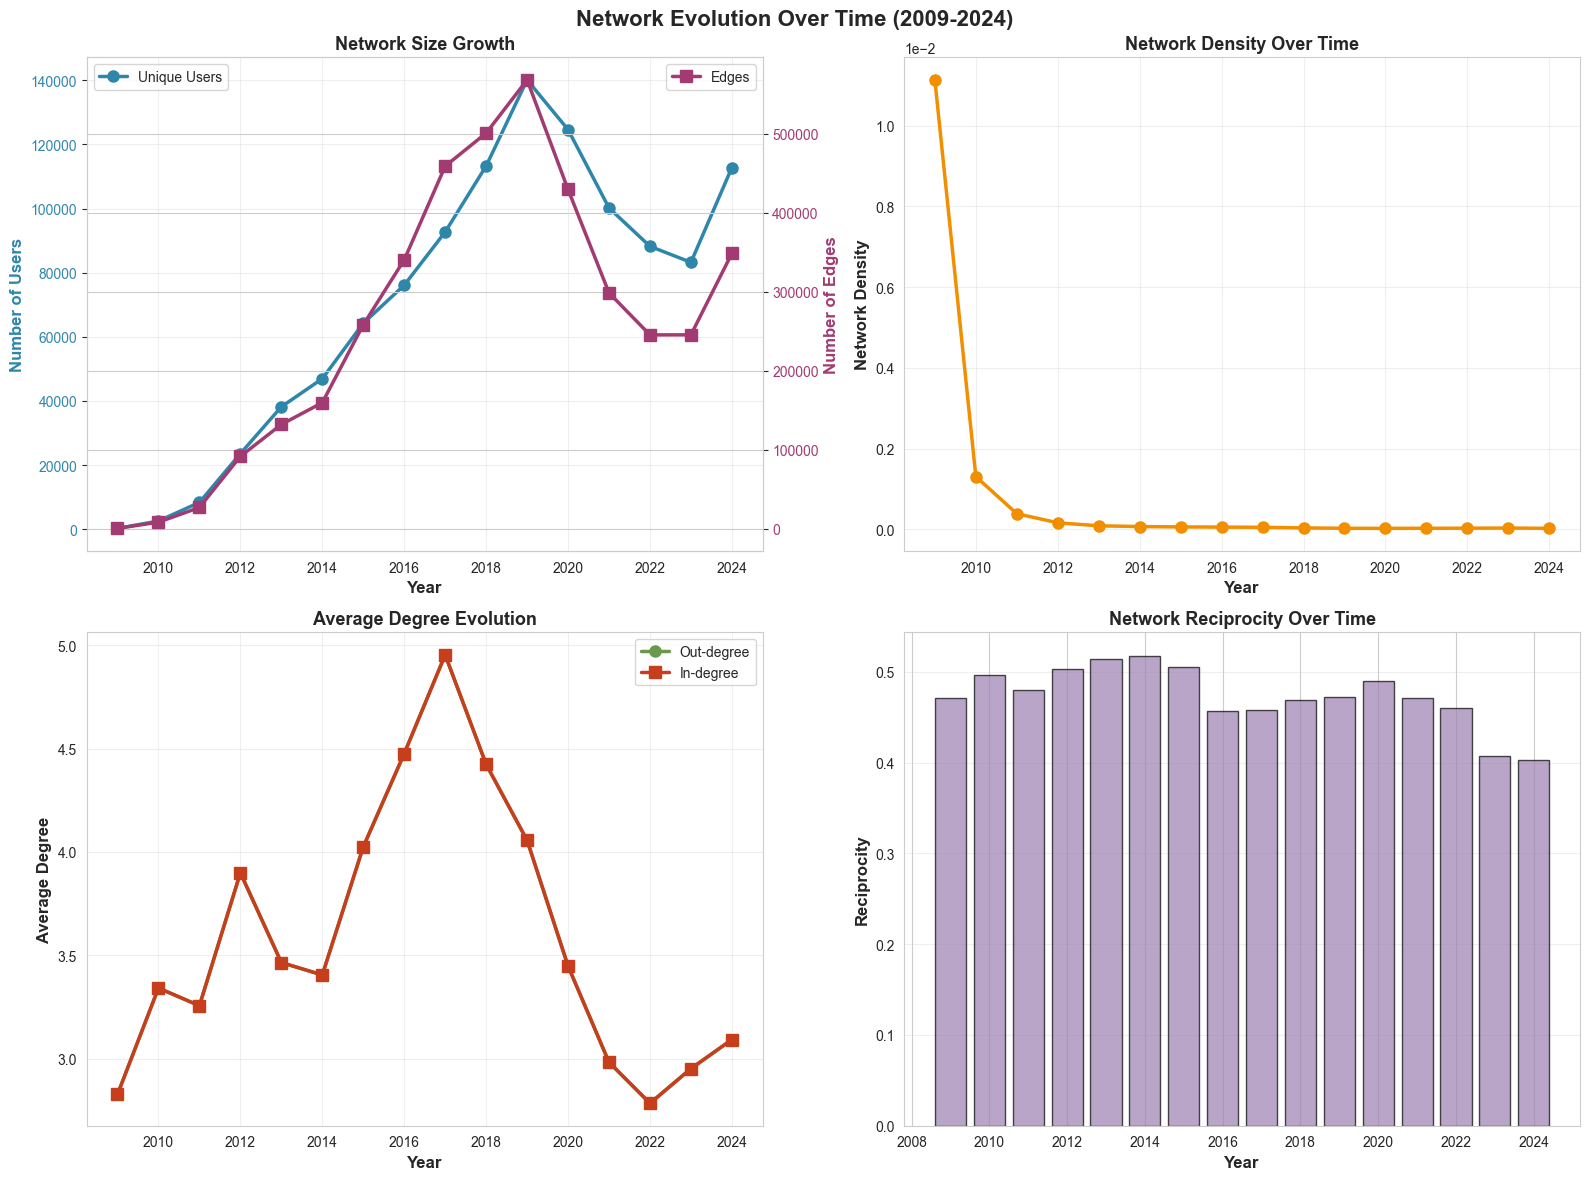

Figure saved: network_evolution.png


In [16]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Network Evolution Over Time (2009-2024)', fontsize=16, fontweight='bold')

# Plot 1: Network size growth
ax1 = axes[0, 0]
ax1_twin = ax1.twinx()
ax1.plot(df_timeline['year'], df_timeline['num_nodes'], marker='o', linewidth=2.5, 
         markersize=8, color='#2E86AB', label='Unique Users')
ax1_twin.plot(df_timeline['year'], df_timeline['num_edges'], marker='s', linewidth=2.5, 
              markersize=8, color='#A23B72', label='Edges')
ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Users', fontsize=12, color='#2E86AB', fontweight='bold')
ax1_twin.set_ylabel('Number of Edges', fontsize=12, color='#A23B72', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='#2E86AB')
ax1_twin.tick_params(axis='y', labelcolor='#A23B72')
ax1.set_title('Network Size Growth', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left', fontsize=10)
ax1_twin.legend(loc='upper right', fontsize=10)

# Plot 2: Density evolution
ax2 = axes[0, 1]
ax2.plot(df_timeline['year'], df_timeline['density'], marker='o', linewidth=2.5, 
         markersize=8, color='#F18F01')
ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_ylabel('Network Density', fontsize=12, fontweight='bold')
ax2.set_title('Network Density Over Time', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Plot 3: Average degree evolution
ax3 = axes[1, 0]
ax3.plot(df_timeline['year'], df_timeline['avg_degree_out'], marker='o', linewidth=2.5, 
         markersize=8, color='#6A994E', label='Out-degree')
ax3.plot(df_timeline['year'], df_timeline['avg_degree_in'], marker='s', linewidth=2.5, 
         markersize=8, color='#C73E1D', label='In-degree')
ax3.set_xlabel('Year', fontsize=12, fontweight='bold')
ax3.set_ylabel('Average Degree', fontsize=12, fontweight='bold')
ax3.set_title('Average Degree Evolution', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=10)

# Plot 4: Reciprocity evolution
ax4 = axes[1, 1]
ax4.bar(df_timeline['year'], df_timeline['reciprocity'], color='#9C7FB1', alpha=0.7, edgecolor='black')
ax4.set_xlabel('Year', fontsize=12, fontweight='bold')
ax4.set_ylabel('Reciprocity', fontsize=12, fontweight='bold')
ax4.set_title('Network Reciprocity Over Time', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(config['fig_dir'], 'network_evolution.png'), dpi=config['plot_dpi'], bbox_inches='tight')
plt.show()
print("Figure saved: network_evolution.png")

### Community Evolution

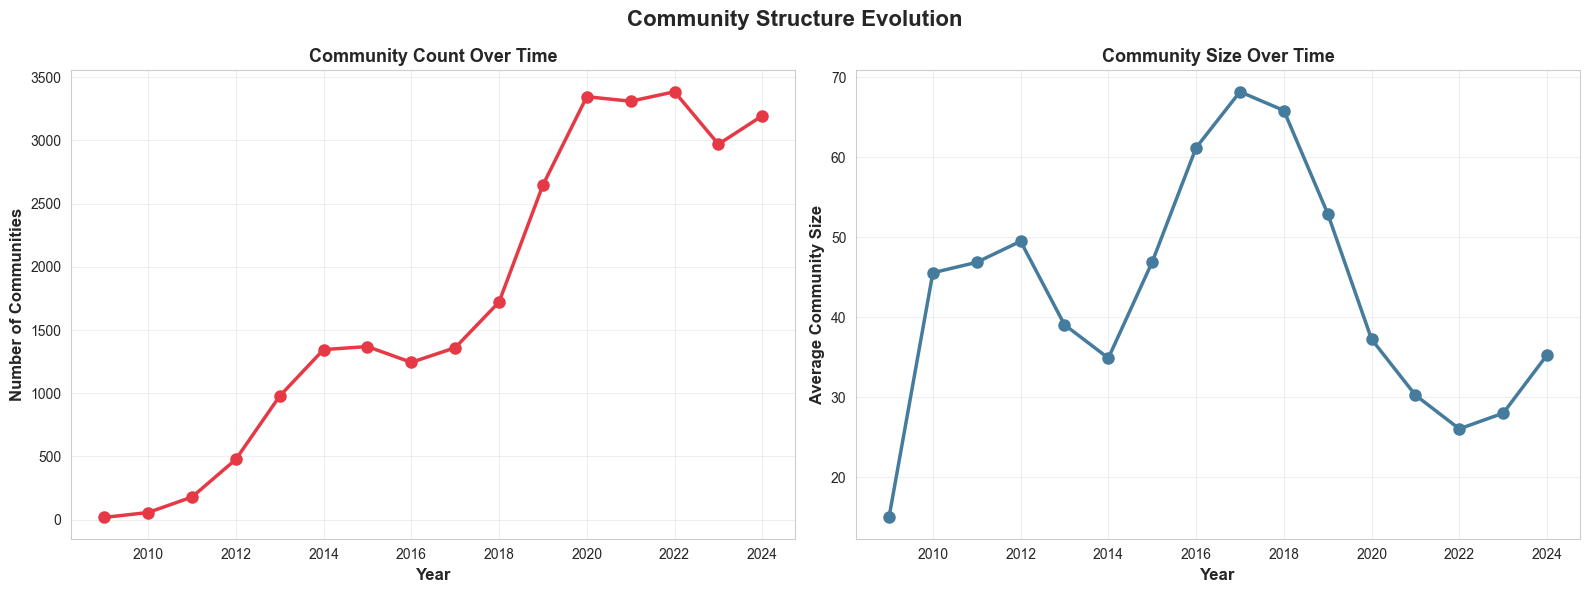

Figure saved: community_evolution.png


In [17]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Community Structure Evolution', fontsize=16, fontweight='bold')

# Plot 1: Number of communities
ax1 = axes[0]
ax1.plot(df_timeline['year'], df_timeline['num_communities'], marker='o', linewidth=2.5, 
         markersize=8, color='#E63946')
ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Communities', fontsize=12, fontweight='bold')
ax1.set_title('Community Count Over Time', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Average community size
ax2 = axes[1]
ax2.plot(df_timeline['year'], df_timeline['avg_community_size'], marker='o', linewidth=2.5, 
         markersize=8, color='#457B9D')
ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_ylabel('Average Community Size', fontsize=12, fontweight='bold')
ax2.set_title('Community Size Over Time', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(config['fig_dir'], 'community_evolution.png'), dpi=config['plot_dpi'], bbox_inches='tight')
plt.show()
print("Figure saved: community_evolution.png")

### User Persistence Distribution

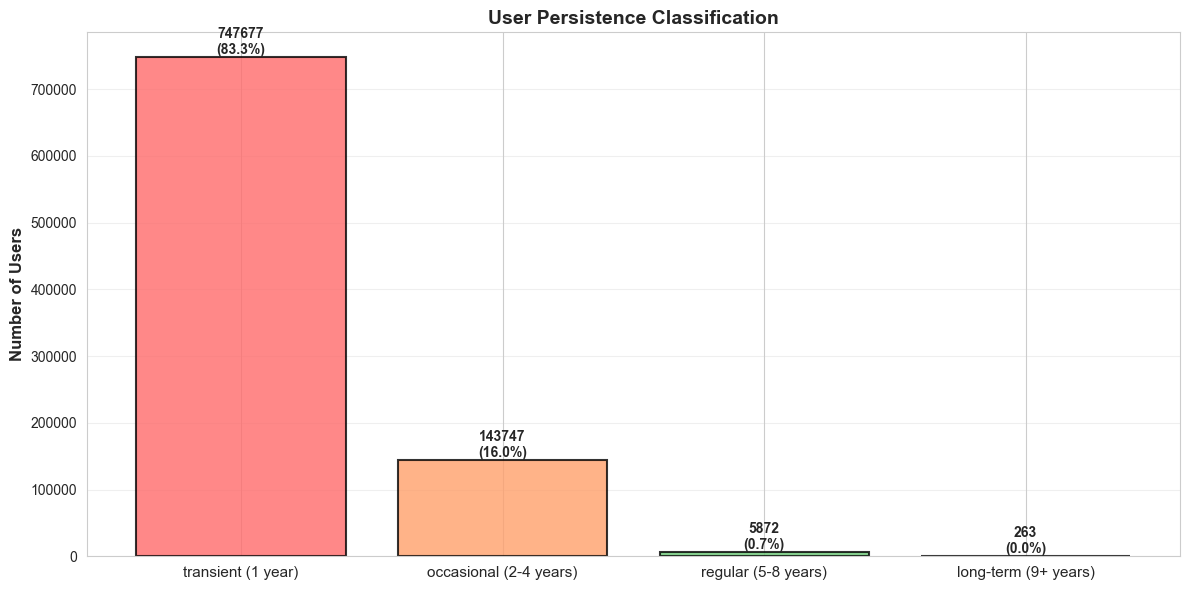

Figure saved: user_persistence.png


In [18]:
fig, ax = plt.subplots(figsize=(12, 6))

categories = ['transient (1 year)', 'occasional (2-4 years)', 'regular (5-8 years)', 'long-term (9+ years)']
counts = [tenure_distribution[cat] for cat in categories]
colors = ['#FF6B6B', '#FFA06B', '#6BCB77', '#4D96FF']

ax.bar(range(len(categories)), counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, fontsize=11)
ax.set_ylabel('Number of Users', fontsize=12, fontweight='bold')
ax.set_title('User Persistence Classification', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add count labels on bars
for i, (cat, count) in enumerate(zip(categories, counts)):
    pct = 100 * count / sum(counts)
    ax.text(i, count, f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(config['fig_dir'], 'user_persistence.png'), dpi=config['plot_dpi'], bbox_inches='tight')
plt.show()
print("Figure saved: user_persistence.png")

## Section 7: Summary and Insights

In [19]:
print("\n" + "="*80)
print("ANALYSIS SUMMARY")
print("="*80)

print(f"\nDataset Coverage:")
print(f"  Years analyzed: {len(results_by_year)} / {len(config['years'])}")
if failed_years:
    print(f"  Failed years: {failed_years}")

print(f"\nNetwork Size (Overall):")
print(f"  Total unique users (all years): {len(user_years):,}")
print(f"  User persistence: {len([1 for u, m in user_influence.items() if len(m['years']) >= 5])} users appear in 5+ years")

print(f"\nNetwork Metrics (2024):")
if 2024 in results_by_year:
    result_2024 = results_by_year[2024]
    print(f"  Nodes: {result_2024['metadata']['num_nodes']:,}")
    print(f"  Edges: {result_2024['metadata']['num_edges']:,}")
    print(f"  Density: {result_2024['metadata']['density']:.6f}")
    print(f"  Communities: {result_2024['communities']['num_communities']}")

print(f"\nKey Findings:")
print(f"  1. User Persistence: {tenure_distribution['long-term (9+ years)']} long-term users ({100*tenure_distribution['long-term (9+ years)']/sum(tenure_distribution.values()):.1f}%)")
print(f"  2. Network Growth: {df_timeline.iloc[-1]['num_nodes']} users in {df_timeline.iloc[-1]['year']:.0f} (from {df_timeline.iloc[0]['num_nodes']} in {df_timeline.iloc[0]['year']:.0f})")
print(f"  3. Density Trend: {'Decreasing' if df_timeline.iloc[-1]['density'] < df_timeline.iloc[0]['density'] else 'Increasing'} (from {df_timeline.iloc[0]['density']:.6f} to {df_timeline.iloc[-1]['density']:.6f})")

print("\nOutput Files Generated:")
for fname in sorted(os.listdir(config['fig_dir'])):
    fpath = os.path.join(config['fig_dir'], fname)
    fsize = os.path.getsize(fpath) / 1024  # KB
    print(f"  {fname} ({fsize:.1f} KB)")

print("\n" + "="*80)
print("Analysis complete.")
print("="*80)


ANALYSIS SUMMARY

Dataset Coverage:
  Years analyzed: 16 / 16

Network Size (Overall):
  Total unique users (all years): 897,559
  User persistence: 6135 users appear in 5+ years

Network Metrics (2024):
  Nodes: 112,788
  Edges: 348,802
  Density: 0.000027
  Communities: 3195

Key Findings:
  1. User Persistence: 263 long-term users (0.0%)
  2. Network Growth: 112788.0 users in 2024 (from 255.0 in 2009)
  3. Density Trend: Decreasing (from 0.011132 to 0.000027)

Output Files Generated:
  community_evolution.png (116.2 KB)
  network_evolution.png (228.1 KB)
  user_persistence.png (59.2 KB)

Analysis complete.
